In [150]:
import numpy as np
import torch
from scipy.signal import welch
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


# Load models
generator = load_model("saved_models/generator_52.keras")
posterior = torch.load("saved_models/trained_sbi_posterior.pt")


# --- Lorentzian Fit Model ---
def lorentzian(f, A, f0, gamma):
    return A / (1 + ((f - f0) / gamma)**2)

# --- Safe Q Estimation ---


def compute_lorentzian_q(series, fs=1.0, f_window=(0.01, 0.5)):
    """
    Compute the Q-factor from Lorentzian fit of the PSD.

    Parameters:
    - series (array): 1D light curve (flux values)
    - fs (float): Sampling frequency (default 1.0 Hz)
    - f_window (tuple): Frequency range to search for peak

    Returns:
    - Q (float): Quality factor of Lorentzian peak (or 0.0 if fit fails)
    """
    try:
        # Compute PSD
        f, Pxx = welch(series.squeeze(), fs=fs, nperseg=256)

        # Frequency window to focus on possible QPOs
        mask = (f > f_window[0]) & (f < f_window[1])
        f_peak = f[mask]
        Pxx_peak = Pxx[mask]

        # Fit Lorentzian: A / (1 + ((f - f0) / gamma)^2)
        p0 = [np.max(Pxx_peak), f_peak[np.argmax(Pxx_peak)],
              0.01]  # [A, f0, gamma]
        popt, _ = curve_fit(lorentzian, f_peak, Pxx_peak, p0=p0, maxfev=5000)
        A, f0, gamma = popt

        if gamma <= 0 or f0 <= 0:
            print("Lorentzian fit returned non-physical gamma or f0. Setting Q = 0.")
            return 0.0

        Q = f0 / gamma
        return Q

    except Exception as e:
        print(f"Lorentzian fit failed: {e}. Setting Q = 0.")
        return 0.0


# --- QPO Detection with SBI Posterior ---
def detect_qpo_sbi(curve, posterior, fs=1.0, show_plot=False):
    f, Pxx = welch(curve.squeeze(), fs=fs, nperseg=256)
    x_obs = torch.tensor(Pxx, dtype=torch.float32)

    # Posterior sampling
    samples = posterior.sample((500,), x=x_obs, show_progress_bars=False)
    fc_samples = samples[:, 0].numpy()
    amp_samples = samples[:, 1].numpy()

    fc_mean = fc_samples.mean()
    fc_std = fc_samples.std()
    amp_mean = amp_samples.mean()

    Q = compute_lorentzian_q(curve, fs=fs)

    print(
        f"Posterior fc range: {fc_samples.min():.3f} – {fc_samples.max():.3f}")
    print(
        f"Posterior amp range: {amp_samples.min():.3f} – {amp_samples.max():.3f}")
    print(f"Q = {Q:.2f} | fc_std = {fc_std:.3f} | amp_mean = {amp_mean:.3f}")

    if show_plot:
        plt.figure(figsize=(12, 4))
        plt.semilogy(f, Pxx)
        plt.title("PSD of Input Light Curve")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Score-based decision
    score = np.log1p(Q) + amp_mean - fc_std
    has_qpo = score > 2.20

    return {
        "fc_mean": fc_mean,
        "fc_std": fc_std,
        "amp_mean": amp_mean,
        "Q": Q,
        "qpo": has_qpo,
        "score": score,
        "samples": samples
    }

/var/folders/15/7vdcd9756072lbp614rqt18c0000gn/T/ipykernel_94016/93730237.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  posterior = torch.load("saved_models/trained_s

In [135]:
# Load data
data = np.loadtxt("data/ltcrv4bands_rej_dt100.dat")
bands = [data[:, i] for i in range(4)]

print(" QPO Detection on XMM-Newton Bands (REJ1034+396)\n")

for i, band in enumerate(bands):
    print(f"Band {i+1}:")
    result = detect_qpo_sbi(band, posterior, fs=1.0, show_plot=False)
    print(
        f"→ fc_mean: {result['fc_mean']:.3f}, fc_std: {result['fc_std']:.3f}")
    print(f"→ amp_mean: {result['amp_mean']:.3f}, Q: {result['Q']:.2f}")
    print(
        f"→ QPO Detected? {'YES' if result['qpo'] else 'NO'} | Score: {result['score']:.2f}\n")

 QPO Detection on XMM-Newton Bands (REJ1034+396)

Band 1:
Posterior fc range: 0.010 – 0.495
Posterior amp range: 0.637 – 0.975
Q = 2.71 | fc_std = 0.107 | amp_mean = 0.797
→ fc_mean: 0.223, fc_std: 0.107
→ amp_mean: 0.797, Q: 2.71
→ QPO Detected? NO | Score: 2.00

Band 2:
Posterior fc range: 0.015 – 0.497
Posterior amp range: 0.602 – 0.997
Q = 5.52 | fc_std = 0.117 | amp_mean = 0.800
→ fc_mean: 0.225, fc_std: 0.117
→ amp_mean: 0.800, Q: 5.52
→ QPO Detected? YES | Score: 2.56

Band 3:
Posterior fc range: 0.011 – 0.495
Posterior amp range: 0.601 – 0.999
Q = 5.39 | fc_std = 0.122 | amp_mean = 0.802
→ fc_mean: 0.224, fc_std: 0.122
→ amp_mean: 0.802, Q: 5.39
→ QPO Detected? YES | Score: 2.53

Band 4:
Lorentzian fit returned non-physical gamma or f0. Setting Q = 0.
Posterior fc range: 0.012 – 0.499
Posterior amp range: 0.604 – 1.000
Q = 0.00 | fc_std = 0.124 | amp_mean = 0.807
→ fc_mean: 0.250, fc_std: 0.124
→ amp_mean: 0.807, Q: 0.00
→ QPO Detected? NO | Score: 0.68



In [151]:
import tensorflow as tf

# Load your trained generator and posterior (if not already loaded)
generator = tf.keras.models.load_model(
    "saved_models/generator_52.keras")
# posterior = torch.load("trained_sbi_posterior.pt")  # already loaded

latent_dim = 100
num_samples = 100
results = []

# Range of test values for frequency and amplitude
fc_range = (0.01, 0.5)
amp_range = (0.6, 1)

for i in range(num_samples):
    # Random test params
    fc = np.random.uniform(*fc_range)
    amp = np.random.uniform(*amp_range)

    # Generate QPO light curves
    z = tf.random.normal((1, latent_dim))

    label_qpo = tf.convert_to_tensor([[fc, amp]], dtype=tf.float32)

    signal_qpo = generator([z, label_qpo], training=False).numpy().squeeze()

    # Detect QPO
    result_qpo = detect_qpo_sbi(signal_qpo, posterior, fs=1.0, show_plot=False)

    results.append({
        "true_qpo": 1,
        "fc": fc,
        "amp": amp,
        "detected": int(result_qpo["qpo"]),
        "score": result_qpo["score"],
        "Q": result_qpo["Q"],
        "amp_mean": result_qpo["amp_mean"],
        "fc_std": result_qpo["fc_std"]
    })

Posterior fc range: 0.014 – 0.499
Posterior amp range: 0.602 – 0.996
Q = 3.91 | fc_std = 0.125 | amp_mean = 0.799
Posterior fc range: 0.016 – 0.500
Posterior amp range: 0.605 – 0.992
Q = 3.90 | fc_std = 0.130 | amp_mean = 0.791
Posterior fc range: 0.012 – 0.499
Posterior amp range: 0.600 – 1.000
Q = 3.93 | fc_std = 0.129 | amp_mean = 0.801
Posterior fc range: 0.011 – 0.496
Posterior amp range: 0.601 – 0.999
Q = 3.83 | fc_std = 0.131 | amp_mean = 0.794
Posterior fc range: 0.010 – 0.496
Posterior amp range: 0.600 – 1.000
Q = 3.83 | fc_std = 0.122 | amp_mean = 0.799
Posterior fc range: 0.012 – 0.493
Posterior amp range: 0.600 – 0.999
Q = 3.58 | fc_std = 0.123 | amp_mean = 0.812
Posterior fc range: 0.010 – 0.499
Posterior amp range: 0.608 – 0.977
Q = 3.97 | fc_std = 0.127 | amp_mean = 0.780
Posterior fc range: 0.014 – 0.500
Posterior amp range: 0.600 – 1.000
Q = 3.98 | fc_std = 0.135 | amp_mean = 0.806
Posterior fc range: 0.011 – 0.499
Posterior amp range: 0.605 – 1.000
Q = 3.94 | fc_std =

In [152]:
import pandas as pd
df = pd.DataFrame(results)
# Uncomment to ignore the failed cases Lorentzian fit returned non-physical gamma or f0
# df = df[df['Q'] != 0]
accuracy = (df['true_qpo'] == df['detected']).mean()
print(f"Detector Accuracy on GAN samples: {accuracy*100:.2f}%")
df["detection_status"] = df["detected"].apply(lambda x: "Detected" if x == 1 else "Failed")

df.to_csv("gan_qpo_detection_results.csv", index=False)

Detector Accuracy on GAN samples: 97.00%


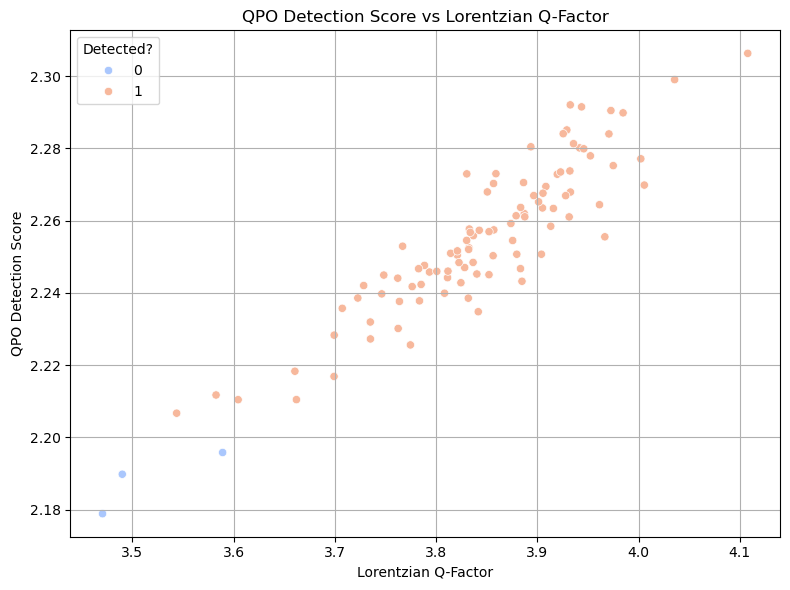

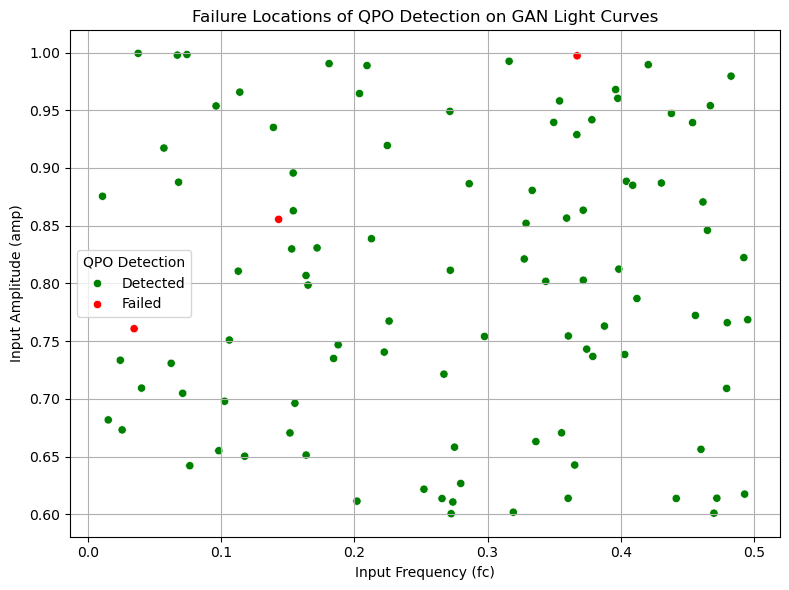

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Plot 1: QPO Detection Score vs Lorentzian Q-Factor ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Q", y="score", hue="detected", palette="coolwarm")
plt.title("QPO Detection Score vs Lorentzian Q-Factor")
plt.xlabel("Lorentzian Q-Factor")
plt.ylabel("QPO Detection Score")
plt.grid(True)
plt.legend(title="Detected?")
plt.tight_layout()
plt.savefig("qpo_score_vs_qfactor.png")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df, x="fc", y="amp", hue="detection_status", palette={"Detected": "green", "Failed": "red"}
)
plt.title("Failure Locations of QPO Detection on GAN Light Curves")
plt.xlabel("Input Frequency (fc)")
plt.ylabel("Input Amplitude (amp)")
plt.grid(True)
plt.legend(title="QPO Detection")
plt.tight_layout()
plt.savefig("qpo_failure_locations.png")
plt.show()

